In [ ]:
%%HTML
<style> code {background-color : pink !important;} </style>

Vehicle Detection using SVMs
===

### Vehicle Detection

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import time
from sklearn.preprocessing import StandardScaler

from default_params import *
from utils import *
from feature_ex import *
from heat import *

%matplotlib inline

In [2]:
# Save model, scaler
import os
import pickle
from sklearn.externals import joblib
VEHICLE_MODEL_PKL='vehicle_model.pkl'
VEHICLE_SCALER_PKL='vehicle_scaler.pkl'
def rm_models_scaler () :
    try :
        for f in glob.glob(VEHICLE_MODEL_PKL) :
            os.remove (f)
            print ("Removed {}".format(f))
        for f in glob.glob (VEHICLE_SCALER_PKL) :
            os.remove (f)
            print ("Removed {}".format (f))
    except :
        print ("Unable to remove existing models")
def save_models_scaler (svc, scaler) :
    rm_models_scaler () # Remove existing models, scaler
    joblib.dump (svc, VEHICLE_MODEL_PKL)
    joblib.dump (scaler, VEHICLE_SCALER_PKL)
def load_models_scaler () :
    return joblib.load (VEHICLE_MODEL_PKL), joblib.load (VEHICLE_SCALER_PKL)

#save_models_scaler (svc, X_scaler)

# To use saved models, uncomment the following line
svc, X_scaler = load_models_scaler()
    


/home/shashigk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/shashigk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:
## Utility to slide windows common between video pipeline and image pipeline
def create_sliding_windows (image) :    
    y_start_stop96 = [400, 656]
    x_start_stop96 = [500, None]
    windows96 = slide_window(image, x_start_stop=x_start_stop96, y_start_stop=y_start_stop96, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    y_start_stop96_64 = [404, 468]
    x_start_stop96_64 = [832, None]
    windows96_64 = slide_window(image, x_start_stop=x_start_stop96_64, y_start_stop=y_start_stop96_64, 
                    xy_window=(96, 64), xy_overlap=(0.75, 0.5))
    
    y_start_stop128 = [400, 656]
    x_start_stop128 = [500, None]
    windows128 = slide_window(image, x_start_stop=x_start_stop128, y_start_stop=y_start_stop128, 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    
    y_start_stop160 = [400, 656]
    x_start_stop160 = [500, None]
    windows160 = slide_window(image, x_start_stop=x_start_stop160, y_start_stop=y_start_stop160, 
                    xy_window=(160, 160), xy_overlap=(0.5, 0.5))
    
    y_start_stop128_64 = [404, 468]
    x_start_stop128_64 = [832, None]
    windows128_64 = slide_window(image, x_start_stop=x_start_stop128_64, y_start_stop=y_start_stop128_64, 
                                  xy_window=(128, 64), xy_overlap=(0.75, 0.5))
    

    ## Experimental windows --- for reference.    
    #windowcustomlist = []
    #windowcustomlist.append (((884, 404), (1012,472)))
    #windowcustomlist.append (((884, 404), (1012,472)))
    #windowcustomlist.append (((860, 404), (988, 468)))
    #windowcustomlist.append (((860, 404), (988, 468)))
        
    #windows = windows32 + windows64 + windows96 + windows128
        
        
    windows = windows96 + windows96_64 + windows128 + windows128_64  #+ windows160 #+ windowcustomlist
    return windows

## Individual image processing pipeline. 
## IMPORTANT: THIS DOES NOT CONVERT RGB2BGR unlike the 
## video pipeline. It assumes image is in BGR format already.
def process_image (image, svc, X_scaler, plotRes=False):
    orient = DEFAULT_ORIENT
    pix_per_cell = DEFAULT_PIX_PER_CELL
    cell_per_block = DEFAULT_CELL_PER_BLOCK
    spatial_size = DEFAULT_SPATIAL_SIZE
    hist_bins = DEFAULT_HIST_BIN
    
    windows = create_sliding_windows (image)

    hot_windows = search_windows(image, windows, svc, X_scaler)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    if plotRes :
        window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
        fSlidingWins, axSlidinWins = plt.subplots (figsize=(10, 10))
        axSlidinWins.set_title ('Sliding Windows')
        axSlidinWins.imshow (window_img)
        
        hwindow_img = draw_boxes(image, hot_windows, color=(255, 0, 0), thick=6)
        fHotWins, axHotWins = plt.subplots (figsize=(10, 10))
        axHotWins.set_title ('Hot Windows')
        axHotWins.imshow (hwindow_img)
        
        fBoxImg, axBoxImg = plt.subplots (figsize=(10,10))
        axBoxImg.set_title ('Car Identification')
        axBoxImg.imshow (draw_img)
        
        fHeatMap, axHeatMap = plt.subplots(figsize=(10,10))
        axHeatMap.set_title('Heat Map')
        axHeatMap.imshow(heatmap, cmap='hot')

    #window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    return draw_img

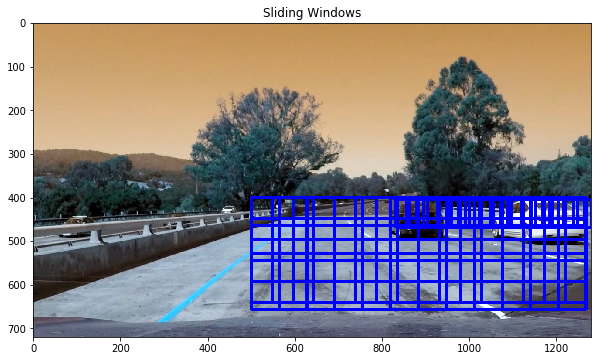

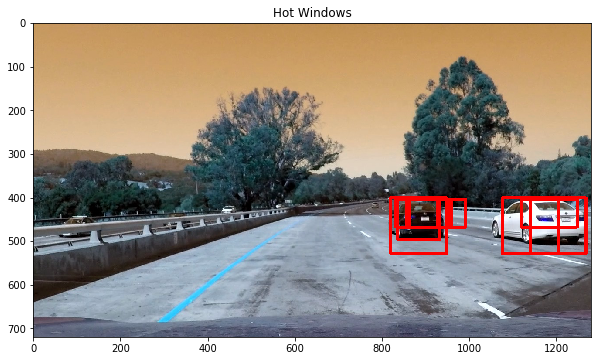

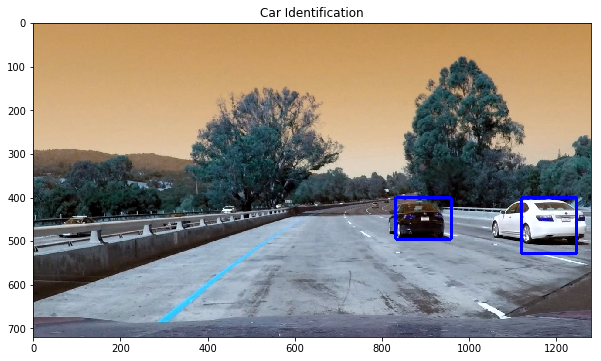

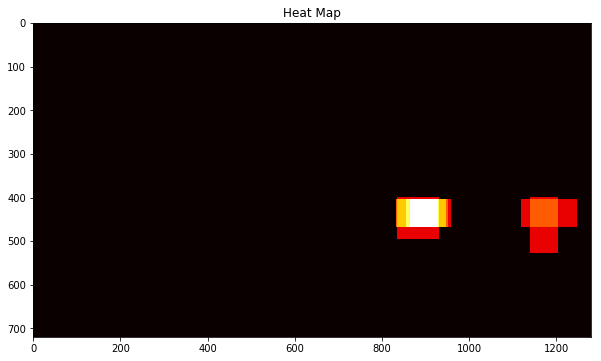

In [4]:
outimg=process_image (cv2.imread('../data/test_images/test1.jpg'), svc, X_scaler, True)

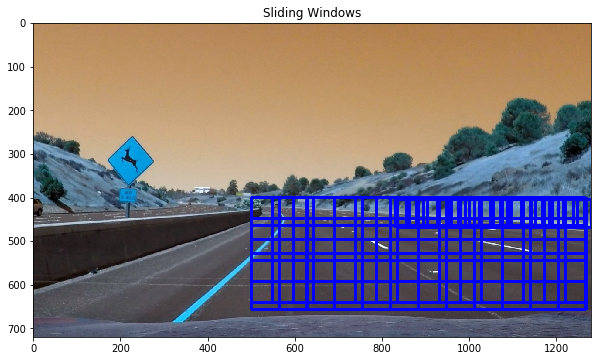

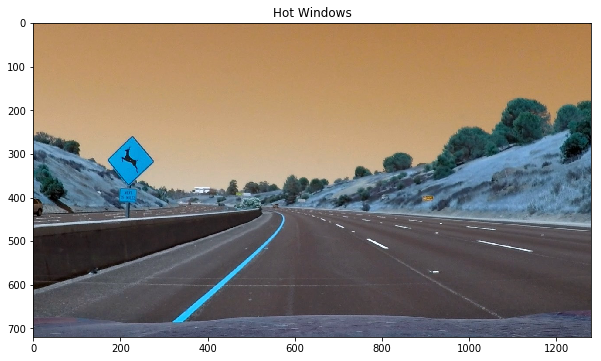

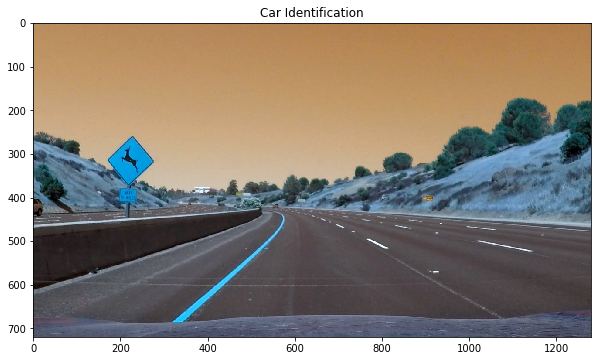

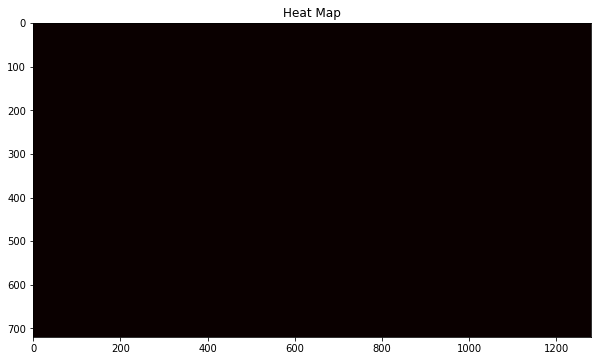

In [5]:
outimg=process_image (cv2.imread('../data/test_images/test2.jpg'), svc, X_scaler, True)

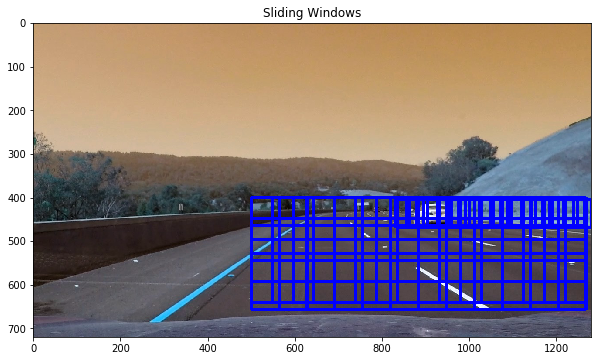

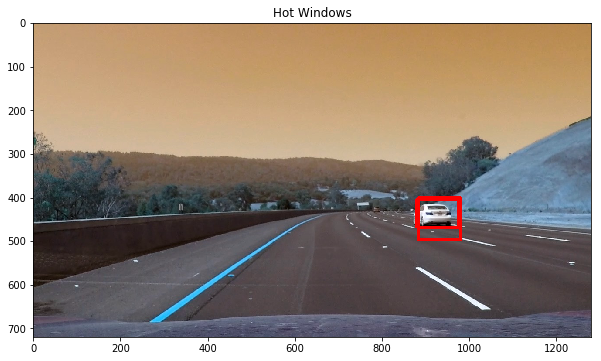

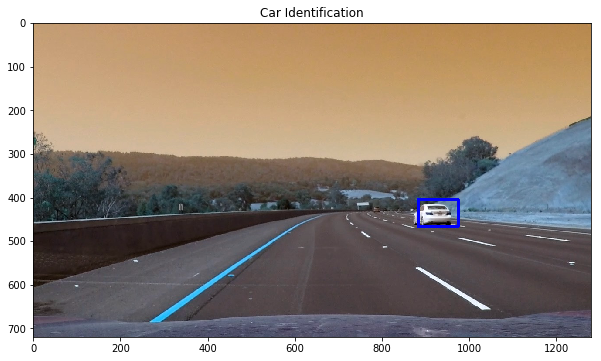

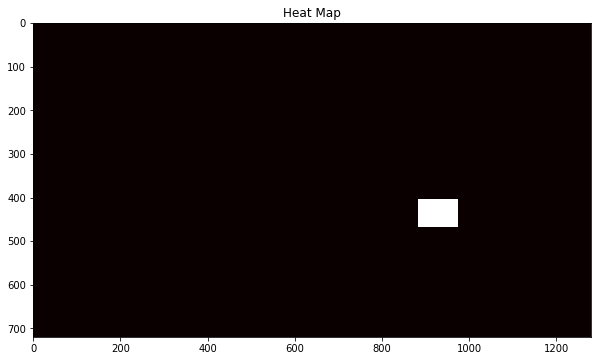

In [6]:
outimg=process_image (cv2.imread('../data/test_images/test3.jpg'), svc, X_scaler, True)

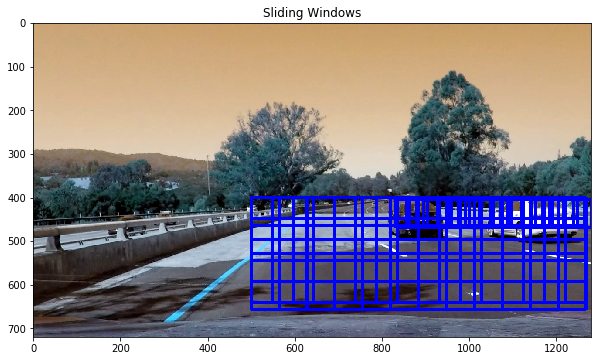

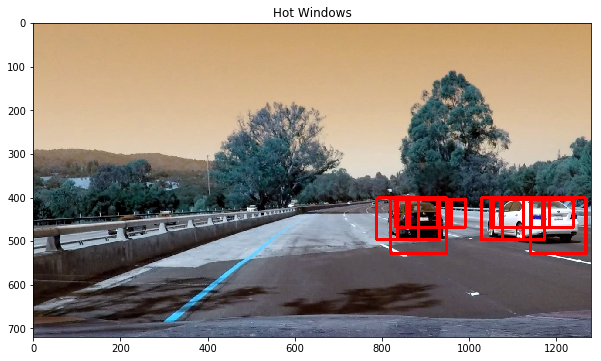

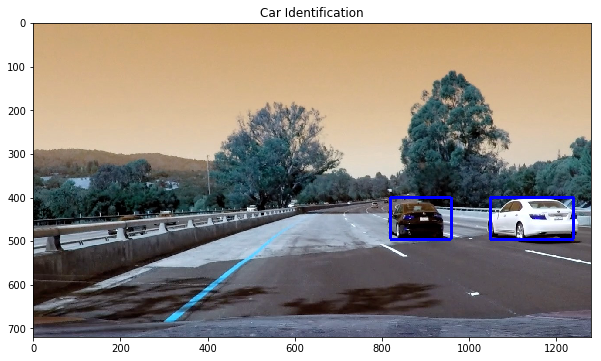

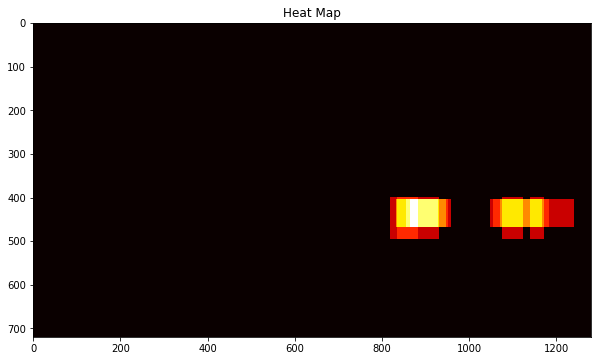

In [7]:
outimg=process_image (cv2.imread('../data/test_images/test4.jpg'), svc, X_scaler, True)

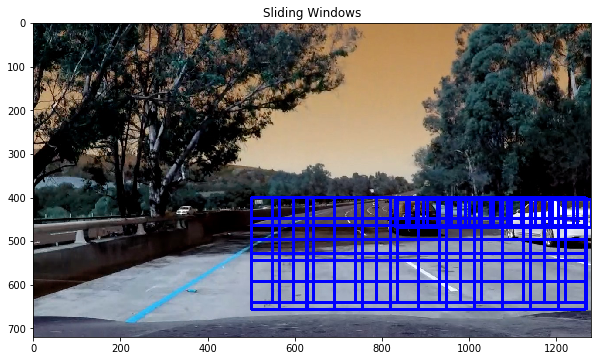

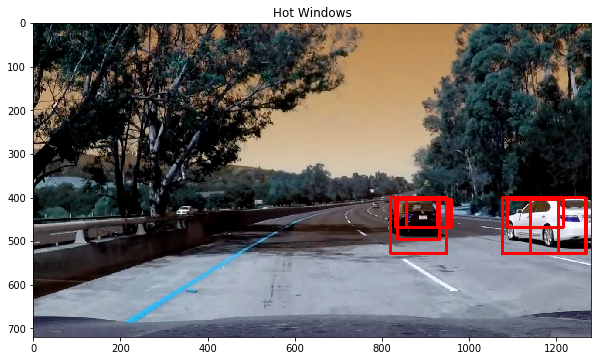

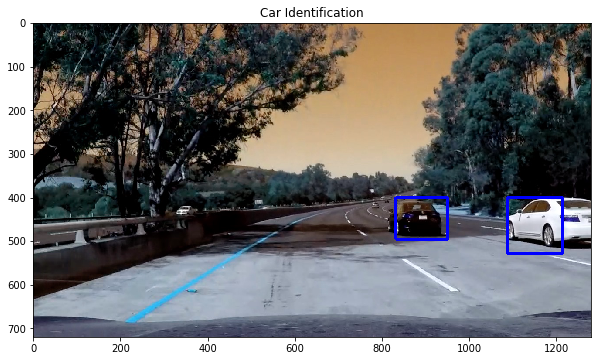

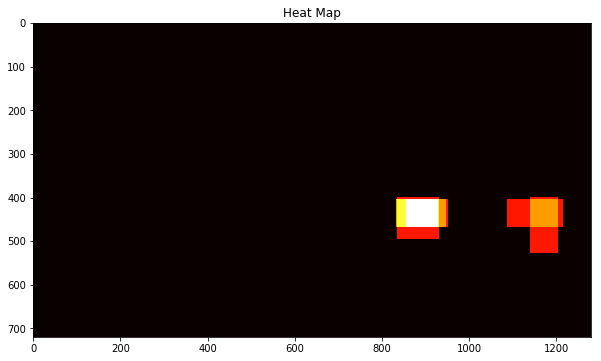

In [8]:
outimg=process_image (cv2.imread('../data/test_images/test5.jpg'), svc, X_scaler, True)

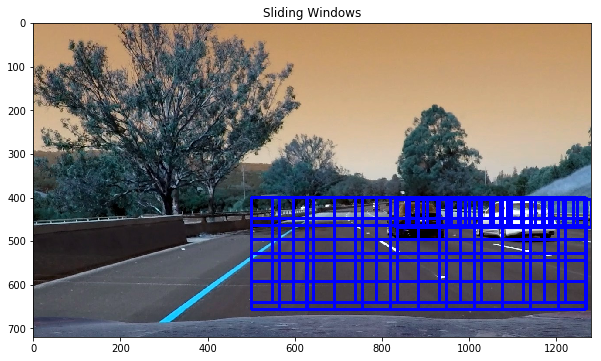

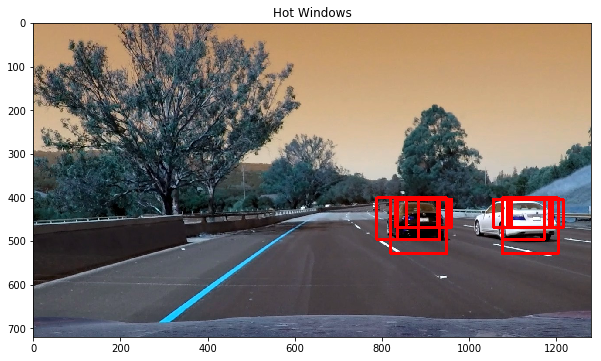

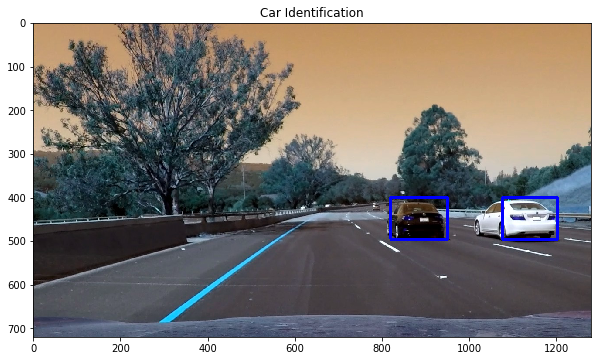

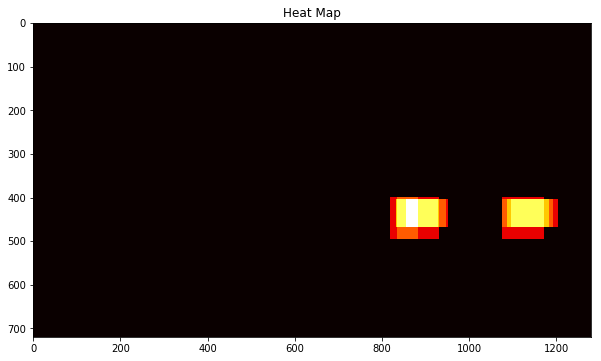

In [9]:
outimg=process_image (cv2.imread('../data/test_images/test6.jpg'), svc, X_scaler, True)

In [10]:
#####################  VIDEO PROCESSING ######################
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio

imageio.plugins.ffmpeg.download()

In [11]:
import collections #mainly need deque

# Vehicle tracker class, it maintains a moving
# average heatmap of size quelen.
class VehicleTracker:
    def __init__(self, frame_size, quelen):
        self.quelen = quelen
        self.sumhmap = collections.deque(maxlen=self.quelen)
        self.frame_count = 0

    def process_frame(self, image):
        self.frame_count += 1
        
        ### IMPORTANT MAKE SURE TO CONVERT RGB to BGR, the
        ### classifier was trained in BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        orient = DEFAULT_ORIENT
        pix_per_cell = DEFAULT_PIX_PER_CELL
        cell_per_block = DEFAULT_CELL_PER_BLOCK
        spatial_size = DEFAULT_SPATIAL_SIZE
        hist_bins = DEFAULT_HIST_BIN
    
        windows = create_sliding_windows (image)

        hot_windows = search_windows(image, windows, svc, X_scaler)
        currheat = np.zeros_like(image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        currheat = add_heat(currheat,hot_windows)
        #currheat = apply_threshold(currheat,1)
        self.sumhmap.append (currheat)
        heat = sum (self.sumhmap)   
        
        # Apply threshold to help remove false positives
        threshold = min (len(self.sumhmap), self.quelen // 2)
        heat = apply_threshold(heat,threshold)
        
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        # DEBUGGING:
        # Draw frame number mainly used for debugging
        #cv2.putText(draw_img, text="FRAME: {}".format(self.frame_count), org=(100,100),fontFace=3,
        #            fontScale=3, color=(0,0,255), thickness=5)
        return draw_img




In [12]:
#def process_frame_avg (image, vehicle) :
#    vehicleTracker = VehicleTracker((720,1280,3))
#    return vehicleTracker.process_frame (image)

def process_video_avg (video_file_in, video_file_out):    
    vehicleTracker = VehicleTracker ((720,1280,3), 10)
    clip = VideoFileClip(video_file_in)
    video_clip = clip.fl_image(vehicleTracker.process_frame)
    %time video_clip.write_videofile(video_file_out, audio=False)

In [13]:
process_video_avg ('test_video.mp4', 'test_video_out.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_video_out.mp4'))

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [01:15<00:02,  2.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 1min 45s, sys: 23.1 s, total: 2min 8s
Wall time: 1min 34s


In [14]:
process_video_avg ('project_video.mp4', 'project_video_out.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_out.mp4'))

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [40:43<00:02,  2.17s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 53min 37s, sys: 10min, total: 1h 3min 38s
Wall time: 40min 50s
